In [67]:
# Create data frames
import pandas as pd
columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']
df_cleveland = pd.read_csv('cleveland.data', na_values='?', names=columns).drop_duplicates()
df_hungarian = pd.read_csv('hungary.data', na_values='?', names=columns).drop_duplicates()
df_long_beach_va = pd.read_csv('long_beach_va.data', na_values='?', names=columns).drop_duplicates()
df_switzerland = pd.read_csv('switzerland.data', na_values='?', names=columns).drop_duplicates()

In [68]:
# Add origin column to each DataFrame
df_cleveland['origin'] = 'Cleveland'
df_hungarian['origin'] = 'Hungary'
df_long_beach_va['origin'] = 'Long Beach VA'
df_switzerland['origin'] = 'Switzerland'

In [69]:
# Combine all DataFrames
df_combined = pd.concat([df_cleveland, df_hungarian, df_switzerland, df_long_beach_va])

In [70]:
df_combined['target'] = (df_combined['num'] > 0).astype(int)

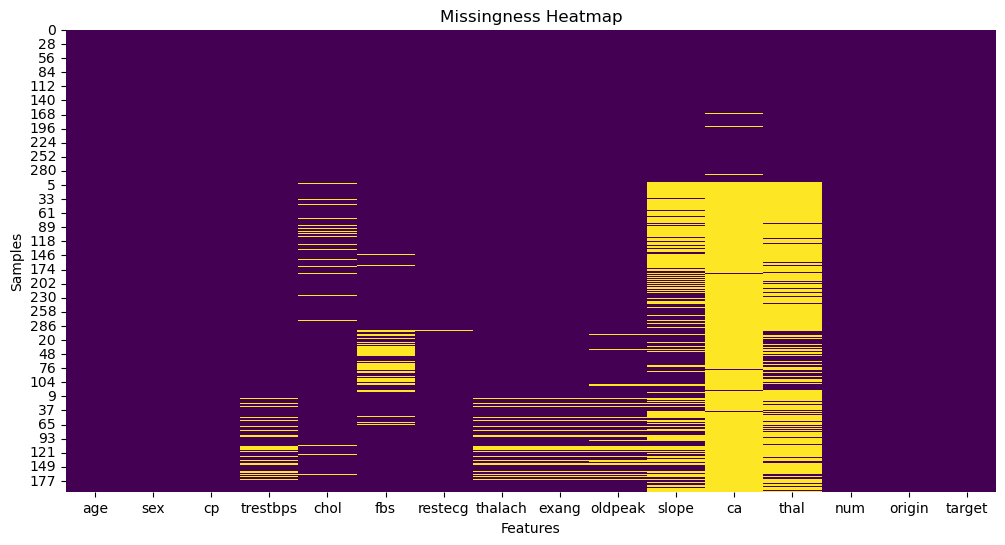

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

# Missingness Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df_combined.isnull(), cbar=False, cmap='viridis')
plt.title('Missingness Heatmap')
plt.xlabel('Features')
plt.ylabel('Samples')
plt.show()

In [72]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 918 entries, 0 to 199
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       918 non-null    float64
 1   sex       918 non-null    float64
 2   cp        918 non-null    float64
 3   trestbps  859 non-null    float64
 4   chol      889 non-null    float64
 5   fbs       828 non-null    float64
 6   restecg   916 non-null    float64
 7   thalach   863 non-null    float64
 8   exang     863 non-null    float64
 9   oldpeak   856 non-null    float64
 10  slope     611 non-null    float64
 11  ca        309 non-null    float64
 12  thal      434 non-null    float64
 13  num       918 non-null    int64  
 14  origin    918 non-null    object 
 15  target    918 non-null    int64  
dtypes: float64(13), int64(2), object(1)
memory usage: 121.9+ KB


In [73]:
missing_counts_by_origin = df_combined.groupby("origin").apply(lambda g: g.isna().sum())

<positron-console-cell-73>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


<positron-console-cell-74>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



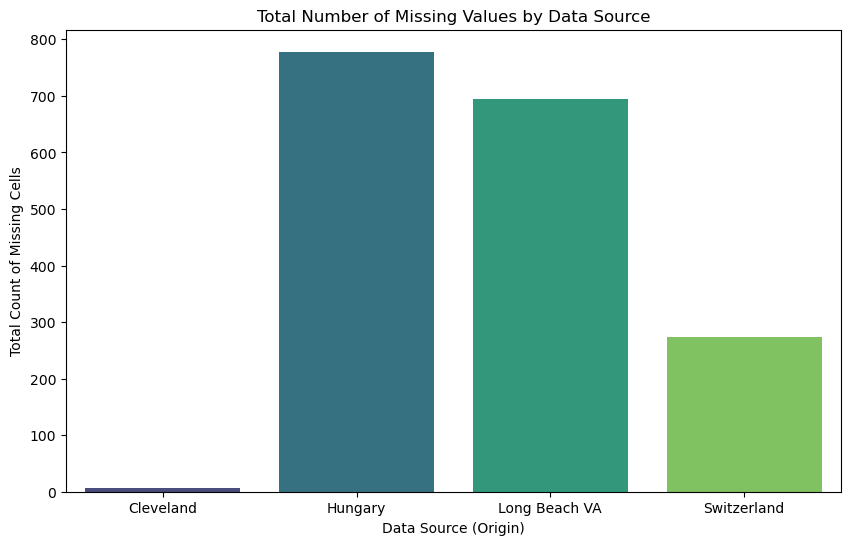

In [74]:
# --- Run this code in the next cell ---

# First, let's get the total number of missing values for each origin by summing across the columns (axis=1)
total_missing_by_origin = missing_counts_by_origin.sum(axis=1)

# Now, let's create a bar plot to visualize these totals
plt.figure(figsize=(10, 6))
sns.barplot(x=total_missing_by_origin.index, y=total_missing_by_origin.values, palette="viridis")
plt.title('Total Number of Missing Values by Data Source')
plt.xlabel('Data Source (Origin)')
plt.ylabel('Total Count of Missing Cells')
plt.show()

In [75]:
# Simple Imputation
from sklearn.impute import SimpleImputer
import numpy as np

# Make a copy of your dataframe to work on, so you always have the original
df_imputed = df_combined.copy()

# Separate columns by type: numerical and categorical
# We will impute them using different strategies (median for numeric, mode for categorical)
numeric_cols = df_imputed.select_dtypes(include=np.number).columns.tolist()
categorical_cols = df_imputed.select_dtypes(include='object').columns.tolist()

# Create an imputer for numerical columns (using the median)
numeric_imputer = SimpleImputer(strategy='median')

# Create an imputer for categorical columns (using the most frequent value)
categorical_imputer = SimpleImputer(strategy='most_frequent')

# Apply the imputers to the respective columns
df_imputed[numeric_cols] = numeric_imputer.fit_transform(df_imputed[numeric_cols])
df_imputed[categorical_cols] = categorical_imputer.fit_transform(df_imputed[categorical_cols])

# Check if there are any missing values left (there shouldn't be!)
print("\n--- Missing values after Simple Imputation ---")
print(df_imputed.isnull().sum())


--- Missing values after Simple Imputation ---
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
origin      0
target      0
dtype: int64


In [76]:
# --- Run this code in the next cell of your notebook ---
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

print("--- Starting Group-Wise KNN Imputation (fixed) ---")

# Define which columns are numeric (for KNN) vs categorical (most_frequent)
num_cols = ["age", "trestbps", "chol", "thalach", "oldpeak", "ca"]   # numeric/continuous-ish
cat_cols = ["sex", "cp", "fbs", "restecg", "exang", "slope", "thal"] # integer-coded categories

# We will NOT impute these with KNN (avoid leakage)
label_cols = ["num", "target"]

imputed_groups = []
origins = df_combined["origin"].unique()

for origin in origins:
    print(f"Processing group: {origin}")
    g = df_combined[df_combined["origin"] == origin].copy()

    # 1) CATEGORICALS → most_frequent (per group)
    if len(cat_cols) > 0:
        cat_imp = SimpleImputer(strategy="most_frequent")
        g[cat_cols] = cat_imp.fit_transform(g[cat_cols])

    # 2) NUMERICS → scale → KNN → inverse scale (per group)
    scaler = StandardScaler()
    knn = KNNImputer(n_neighbors=5)

    Xn = g[num_cols].to_numpy()
    Xn_scaled = scaler.fit_transform(Xn)
    Xn_imp_scaled = knn.fit_transform(Xn_scaled)
    Xn_imp = scaler.inverse_transform(Xn_imp_scaled)
    g[num_cols] = Xn_imp

    # 3) DO NOT alter labels; just carry them through
    # (If any label NaNs exist, handle separately; usually there are none in processed files.)

    # 4) Append imputed group (all columns preserved)
    imputed_groups.append(g)

# Recombine imputed groups; keep original row order
df_knn_imputed = pd.concat(imputed_groups).sort_index()

# Optional: restore dtypes for categorical ints
for c in cat_cols:
    df_knn_imputed[c] = pd.to_numeric(df_knn_imputed[c], errors="coerce").astype("Int64")
df_knn_imputed["origin"] = df_knn_imputed["origin"].astype("category")

print("\n--- Missing values after Group-Wise KNN Imputation (key cols) ---")
print(df_knn_imputed[num_cols + cat_cols].isnull().sum())

print("\n--- First 5 rows of the KNN-imputed DataFrame ---")
print(df_knn_imputed.head())


--- Starting Group-Wise KNN Imputation (fixed) ---
Processing group: Cleveland
Processing group: Hungary
Processing group: Switzerland
Processing group: Long Beach VA

--- Missing values after Group-Wise KNN Imputation (key cols) ---
age         0
trestbps    0
chol        0
thalach     0
oldpeak     0
ca          0
sex         0
cp          0
fbs         0
restecg     0
exang       0
slope       0
thal        0
dtype: int64

--- First 5 rows of the KNN-imputed DataFrame ---
    age  sex  cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  slope   ca  thal  num         origin  target
0  63.0    1   1     145.0  233.0    1        2    150.0      0      2.3      3  0.0     6    0      Cleveland       0
0  32.0    1   1      95.0    0.0    0        0    127.0      0      0.7      1  1.6     7    1    Switzerland       1
0  63.0    1   4     140.0  260.0    0        1    112.0      1      3.0      2  0.0     7    2  Long Beach VA       1
0  28.0    1   2     130.0  132.0    0      

In [84]:
def duplicate_report(df, site_name):
    print(f"\n=== {site_name} ===")
    # exact duplicates across all columns
    n_exact = df.duplicated(keep=False).sum()
    print("Exact duplicates (all columns):", n_exact)

    # duplicates on features only (ignore origin + label)
    feature_cols = [c for c in df.columns if c not in ["origin","num","target"]]
    n_feat_dups = df.duplicated(subset=feature_cols, keep=False).sum()
    print("Duplicates on features (ignoring label/origin):", n_feat_dups)

    # conflicting-label groups: same features, different num
    grp = df.groupby(feature_cols, dropna=False)["num"].nunique()
    conflictings = grp[grp > 1].shape[0]
    print("Conflicting-label groups (same features, different num):", conflictings)

duplicate_report(df_cleveland, "Cleveland")
duplicate_report(df_hungarian, "Hungary")
duplicate_report(df_switzerland, "Switzerland")
duplicate_report(df_long_beach_va, "Long Beach VA")



=== Cleveland ===
Exact duplicates (all columns): 0
Duplicates on features (ignoring label/origin): 0
Conflicting-label groups (same features, different num): 0

=== Hungary ===
Exact duplicates (all columns): 0
Duplicates on features (ignoring label/origin): 0
Conflicting-label groups (same features, different num): 0

=== Switzerland ===
Exact duplicates (all columns): 0
Duplicates on features (ignoring label/origin): 0
Conflicting-label groups (same features, different num): 0

=== Long Beach VA ===
Exact duplicates (all columns): 0
Duplicates on features (ignoring label/origin): 0
Conflicting-label groups (same features, different num): 0


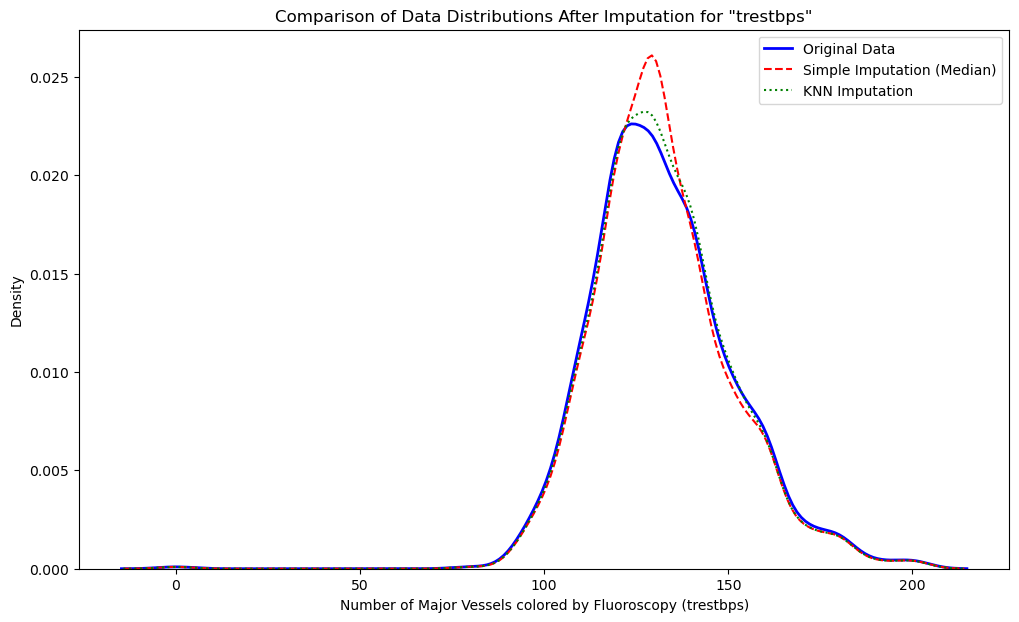

In [77]:
# Set up the plot
plt.figure(figsize=(12, 7))

# Plot the distribution of the original data (where it's not missing)
# We use a kernel density estimate (kde) plot, which is like a smooth histogram.
sns.kdeplot(df_combined['trestbps'].dropna(), label='Original Data', color='blue', linewidth=2)

# Plot the distribution of the data after Simple Imputation
sns.kdeplot(df_imputed['trestbps'], label='Simple Imputation (Median)', color='red', linestyle='--')

# Plot the distribution of the data after KNN Imputation
sns.kdeplot(df_knn_imputed['trestbps'], label='KNN Imputation', color='green', linestyle=':')

# Add titles and labels for clarity
plt.title('Comparison of Data Distributions After Imputation for "trestbps"')
plt.xlabel('Number of Major Vessels colored by Fluoroscopy (trestbps)')
plt.ylabel('Density')
plt.legend()
plt.show()

<positron-console-cell-83>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



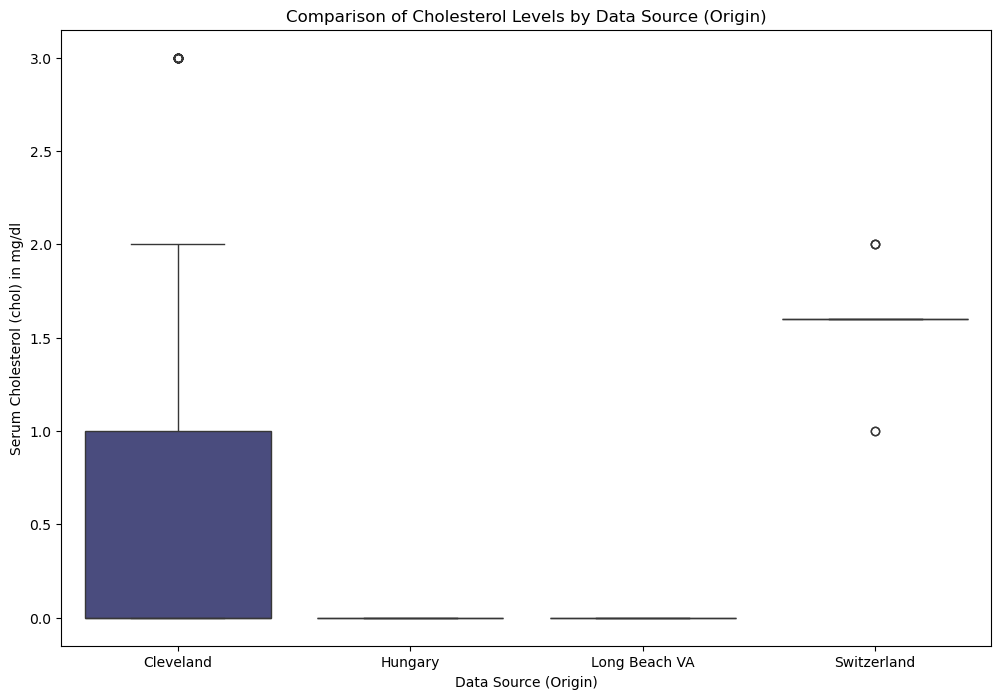

In [ ]:
# --- Run this code in the next cell of your notebook ---

# Set up the plot with a larger size for clarity
plt.figure(figsize=(12, 8))

# Create a box plot using seaborn
# We will use your best dataset: df_knn_imputed
sns.boxplot(data=df_knn_imputed, x='origin', y='oldpeak', palette='viridis')

# Add titles and labels
plt.title('Comparison of Cholesterol Levels by Data Source (Origin)')
plt.xlabel('Data Source (Origin)')
plt.ylabel('Serum Cholesterol (chol) in mg/dl')
plt.show()

<positron-console-cell-79>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



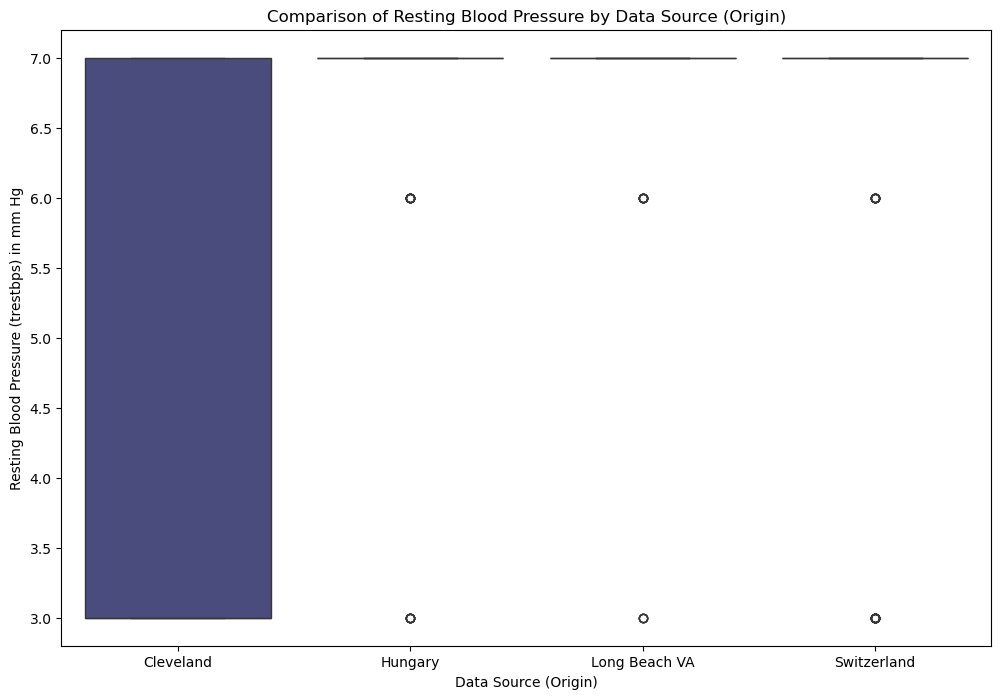

In [79]:
# --- Run this code in the next cell of your notebook ---

# Set up the plot with a larger size for clarity
plt.figure(figsize=(12, 8))

# Create a box plot for 'thalach' using your best dataset: df_knn_imputed
sns.boxplot(data=df_knn_imputed, x='origin', y='thal', palette='viridis')

# Add titles and labels
plt.title('Comparison of Resting Blood Pressure by Data Source (Origin)')
plt.xlabel('Data Source (Origin)')
plt.ylabel('Resting Blood Pressure (trestbps) in mm Hg')
plt.show()